In [1]:
"""
[Package import]
Import some useful packages here
"""

import clip
import torch
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.models import AutoencoderKL
from Models import Voxel2StableDiffusionModel
from transformers import BlipProcessor,BlipForConditionalGeneration
from utils import load_image, to_PIL, transform, decode_img, GetROI
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
[Load Pretrain Models]

Import CLIP, VAE, BLIP, Stable Diffusion pretrain models.
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
modelGeneration = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to(device)
sdPipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",torch_dtype=torch.float16).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
def GetPredictions(target_idx):
    """
    Generate low-level prediction images to target image "target_idx"

    Note that the implementation here is not flexible, we directly choose 4 models here.
    If you're going to run this code, please make sure you have replace the model_paths
    to the path where you're model in.
    
    Also, here we only select subject 1's "training" image

    Parameters:
    - target_idx: The index number of image to predict.

    Returns:
    - Predictions provided by models
    - Target image
    """

    sample_preds = []
    # Load models for bagging
    # Here, we choose model 92, 94, 97, 100 since they have better performance
    model_paths = ['../Models/92/199', '../Models/94/199', '../Models/97/199', '../Models/100/199']
    select_ROIs = [3, 1, 3, 3]
    
    image_path = f'../dataset/subj01/training_split/training_images/{target_idx}.png'
    target_image = transform(load_image(image_path))
    voxel2sd = Voxel2StableDiffusionModel().to(device)
    latent_images = []
    
    for i in range(len(model_paths)):    
        voxel2sd.load_state_dict(torch.load(model_paths[i])['model_state_dict'])
        voxel2sd.eval()
    
        target_ROI = torch.from_numpy(GetROI(target_idx, select_ROIs[i])).to(device).float()
        latent = voxel2sd(target_ROI.reshape(1, -1))
        
        del target_ROI
        
        latentImg = to_PIL(decode_img(latent, vae)[0])
        latent_images.append(latentImg)
    
        del latent
        
        out = transforms.functional.pil_to_tensor(transforms.Resize((384,384))(latentImg)).to(device)
        out = modelGeneration.generate(out.unsqueeze(0)).to(device)
        prompt = processor.decode(out[0], skip_special_tokens=True).replace('blurry ', '')
    
        del out
        
        # print(prompt)
        # latentImg.show()
        # latentImg.save(f"./outputImg/low_{count}.png")
        retrieveImg = sdPipe(prompt=prompt, image=latentImg,strength=0.75, guidance_scale=6).images[0]
        # retrieveImg.show()
        sample_preds.append(retrieveImg)
    return sample_preds, target_image, latent_images

In [4]:
def project_to_CLIP(image):
    """
    Project a image to CLIP space by CLIP model.

    Parameters:
    - image: Image to project.

    Returns:
    - Projected CLIP latent
    """
    with torch.no_grad():
        image = preprocess(image).unsqueeze(0).to(device)
        features = model.encode_image(image)
    return features

In [5]:
def similarity(image1_features, image2_features):
    """
    Calculate similarity of two images by cosine similarity

    Parameters:
    - image1_features: Feature of 1st image
    - image2_features: Feature of 2nd image

    Returns:
    - Similarity of two images
    """

    cos = torch.nn.CosineSimilarity(dim=0)
    return cos(image1_features,image2_features).item()

In [6]:
def CLIP_bagging(sample_preds, latent_images):
    """
    Bagging on given images' prediction by models.

    Parameters:
    - sample_preds: Guided Reconstruction Pipeline predictions. (High-level Pipeline)
    - latent_images: Low-level Pipeline predictions.
    
    Returns:
    - Best result
    """
    best_similarity = 0
    best_image_index = -1
    sims = []
    
    # Project images onto clip space
    sample_feature_vectors = [] # image to feature vectors
    latent_feature_vectors = []
    for sample in sample_preds:
        sample_feature_vectors.append(project_to_CLIP(sample))
    for latent in latent_images:
        latent_feature_vectors.append(project_to_CLIP(latent))
    
    # Compare each High-Level result with Low-level result
    # Select the one has highest similarity
    for i, features in enumerate(sample_feature_vectors):
        sim = similarity(latent_feature_vectors[i][0], features[0])
        sims.append(sim)
        if sim > best_similarity:
            best_similarity = sim
            best_image_index = i
    
    # Visualize the best image for each testing data
    best_image = sample_preds[best_image_index]
    print(f'sims: {sims}')
    return best_image

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

sims: [0.62158203125, 0.56884765625, 0.59228515625, 0.53173828125]


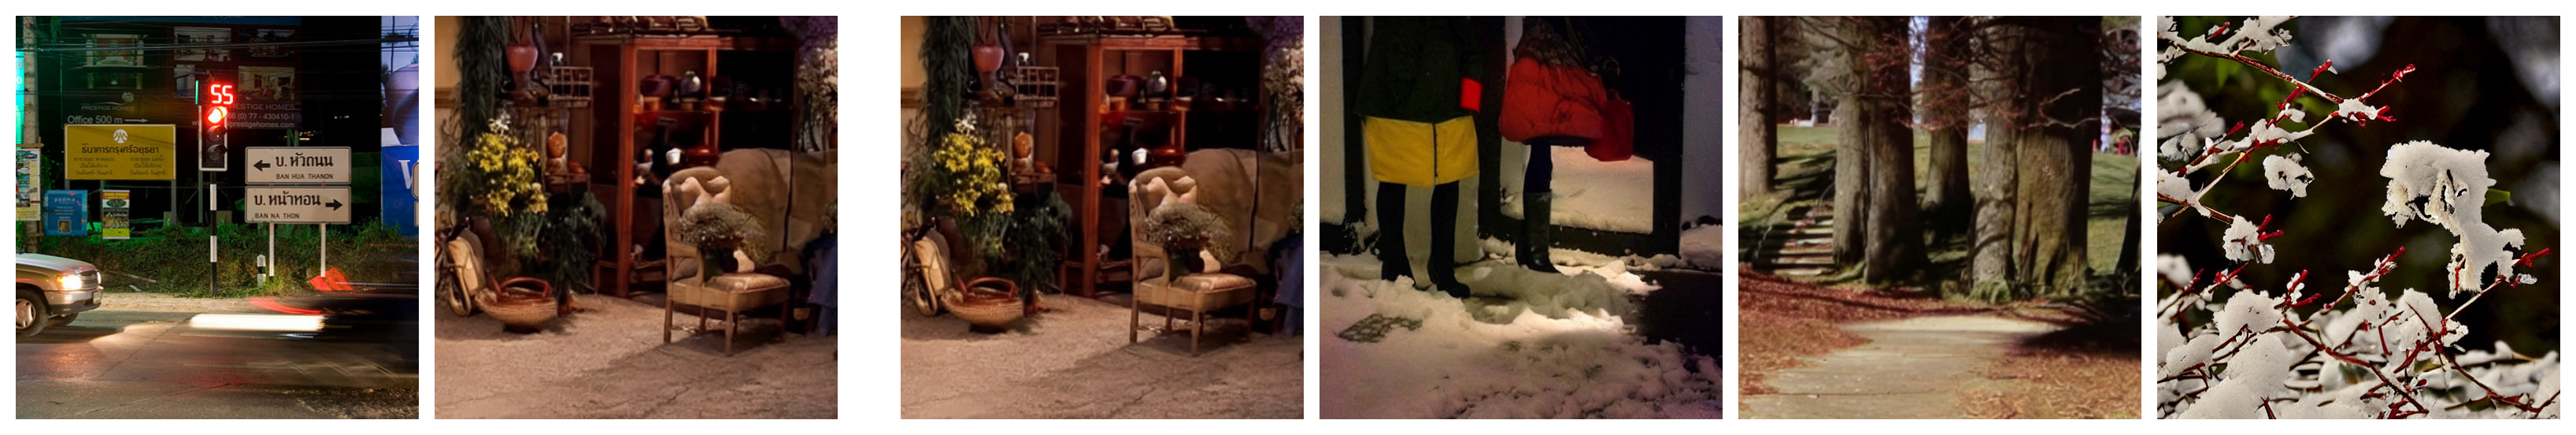

Round 201: 0.57080078125


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
"""
[Bagging Process]

Generate images by our models, then perform bagging by "CLIP_bagging" function.
Show result with compare images.

First image is the original(target) image.
Second image is the best image from bagging process.
The remaining images are predictions by models.

The range of i indicate the images to predict.
"""

sim_records = {}
for i in range(201, 300):
    sample_preds, target_image, latent_images = GetPredictions(i)
    best_image = CLIP_bagging(sample_preds, latent_images)
    
    # best_image.show()
    from PIL import ImageOps
    bg = Image.new('RGB', (3272, 552), '#ffffff')
    target_image_ = ImageOps.expand(to_PIL(target_image[0]), 20, (255, 255, 255))
    best_image_ = ImageOps.expand(best_image, 20, (255, 255, 255))
    
    bg.paste(target_image_, (0, 0))
    bg.paste(best_image_, (20+512, 0))
    for j in range(4):
        pred_image = sample_preds[j]
        pred_image = ImageOps.expand(pred_image, 20, (255, 255, 255)) 
        bg.paste(pred_image, (20+512+20+512+20+40 + (512+20)*j, 0))
    bg.show()
    bg.save(f'../results/result_{i}.png')

    best_latent = project_to_CLIP(best_image)
    original_latent = project_to_CLIP(to_PIL(target_image[0]))
    sim = similarity(best_latent[0], original_latent[0])
    sim_records[i] = sim
    print(f'Round {i}: {sim}')